In [31]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.preprocessing import KBinsDiscretizer, LabelEncoder, StandardScaler
from sklearn.datasets import make_blobs, load_wine

from data_functions import load_data
from calibration import get_calibration_errors, get_ece, get_mce
from numpy.random import default_rng

from parzen_window_classifier import PWC

from functools import partial
rng = default_rng(12345)

In [13]:
data_set_names = pd.read_csv('./data/data_set_ids.csv').name.values

In [14]:
data_set_names

array(['breast-cancer-wisconsin', 'blood-transfusion',
       'pima-indians-diabetes', 'ionosphere', 'sonar', 'biodegradation',
       'vehicle', 'ecoli', 'glass', 'vertebra-column', 'user-knowledge',
       'kc2', 'parkinsons', 'banknote', 'seeds', 'prnn-craps',
       'chscase-vine', 'wine', 'iris', 'segment', 'balance-scale',
       'seismic-bumps', 'steel-plates-fault', 'phoneme', 'satimage',
       'wind'], dtype=object)

In [15]:
for name in data_set_names:
	print(name)
	X, y, _ = load_data(name)
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

	#model = GaussianNB()
	model = PWC(len(np.unique(y)))
	model.fit(X_train, y_train)

	y_pred = model.predict(X_test).round(3)
	accuracy = np.sum(y_test == y_pred) / len(y_pred)

	print(f'Accuracy: {accuracy}')

breast-cancer-wisconsin
Accuracy: 0.9342105263157895
blood-transfusion
Accuracy: 0.7433333333333333
pima-indians-diabetes
Accuracy: 0.711038961038961
ionosphere
Accuracy: 0.624113475177305
sonar
Accuracy: 0.5357142857142857
biodegradation
Accuracy: 0.7582938388625592
vehicle
Accuracy: 0.6194690265486725
ecoli
Accuracy: 0.45925925925925926
glass
Accuracy: 0.4186046511627907
vertebra-column
Accuracy: 0.8306451612903226
user-knowledge
Accuracy: 0.30864197530864196
kc2
Accuracy: 0.7511961722488039
parkinsons
Accuracy: 0.8205128205128205
banknote
Accuracy: 0.994535519125683
seeds
Accuracy: 0.8928571428571429
prnn-craps
Accuracy: 0.925
chscase-vine
Accuracy: 0.75
wine


/home/nico/lmu/active_learning/multi_annotator/data_functions.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = LabelEncoder().fit_transform(X[col])


Accuracy: 0.75
iris
Accuracy: 0.9833333333333333
segment
Accuracy: 0.9426406926406926
balance-scale
Accuracy: 0.86
seismic-bumps
Accuracy: 0.8928571428571429
steel-plates-fault
Accuracy: 0.5238095238095238
phoneme
Accuracy: 0.7252543940795559
satimage
Accuracy: 0.7297822706065319
wind
Accuracy: 0.8429657794676806


In [16]:
def initial_choice(X_train, y_train, budget=5):

	idx = [i for l in [rng.choice(np.where(y_train==c)[0],5)
				    for c in np.unique(y_train)] for i in l]

	mask = np.ones(len(X_train), dtype=bool)
	mask[idx] = False

	p = np.arange(len(idx))
	rng.shuffle(p)
	X_DL = X_train[idx][p]
	y_DL = y_train[idx][p]

	p = np.arange(sum(mask))
	rng.shuffle(p)
	X_DP =  X_train[mask][p]
	y_DP = y_train[mask][p]

	return X_DP, y_DP, X_DL, y_DL


In [17]:
def eval_classifier(classifier, X_test, y_test, results):
	
	y_pred = classifier.predict(X_test)
	results['accuracies'].append(np.round(np.sum(y_pred == y_test) / len(y_test), 3))

	results['mce'].append(np.round(get_mce(y_test, y_pred), 3))
	results['ece'].append(np.round(get_ece(y_test, y_pred), 3))

def select_instances(n, classifier, query_strategy, X_DP, y_DP, X_DL, y_DL):
	
	idx = query_strategy(n, classifier, X_DP, y_DP)

	mask = np.ones(len(X_DP), dtype=bool)
	mask[idx] = False

	X_DL = np.append(X_DL, X_DP[idx], axis=0)
	y_DL = np.append(y_DL, y_DP[idx])

	X_DP = X_DP[mask]
	y_DP = y_DP[mask]

	return X_DP, y_DP, X_DL, y_DL

def margin_qs(n, classifier, X, y):

	p = classifier.predict_proba(X)
	instances_idx = np.argsort(np.diff(np.sort(p, axis=1))[:,-1])[:n]

	return instances_idx

In [26]:
def run_experiment(data_set_name, seed, classifier, nbudget=5, query_strategy=margin_qs, verbose=False):

	X, y, _ = load_data(data_set_name)
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=seed)

	# Standardize
	scaler = StandardScaler().fit(X_train)
	X_train = scaler.transform(X_train)
	X_test = scaler.transform(X_test)

	X_DP, y_DP, X_DL, y_DL = initial_choice(X_train, y_train, nbudget)

	n_classes = len(np.unique(y_test))
	budget = nbudget * n_classes

	if classifier.func == PWC:
		classifier = classifier(n_classes=n_classes)
	else:
		classifier = classifier()
	n_iterations = np.minimum(len(X_test) // (2*budget), 50) 

	results = {'accuracies': [], 'mce': [], 'ece': []}

	for i in range(n_iterations):

		classifier.fit(X_DL, y_DL)
		
		eval_classifier(classifier, X_test, y_test, results)

		if verbose:
			print(f'Iteration: {i}. Accuracy: {results['accuracies'][-1]}. MCE: {results['mce'][-1]}. ECE: {results['ece'][-1]}')

		X_DP, y_DP, X_DL, y_DL = select_instances(budget, classifier, query_strategy, X_DP, y_DP, X_DL, y_DL)
	
	return results

In [27]:
def plot_mean_std(ax, data, x, label, color, linestyle='-'):

	mean = np.mean(data, axis=0)
	std = np.std(data, axis=0)

	lower_bound = np.maximum(mean - std, 0)  # Prevent negative values
	upper_bound = mean + std

	ax.plot(x, mean, label=label, color=color, linewidth=2, linestyle=linestyle)
	ax.fill_between(x, lower_bound, upper_bound, color=color, alpha=0.3, label=f"±1 Std Dev {label}")

In [28]:
len(data_set_names)

26

In [45]:
partial(PWC, metric='rbf').func == PWC

True

breast-cancer-wisconsin


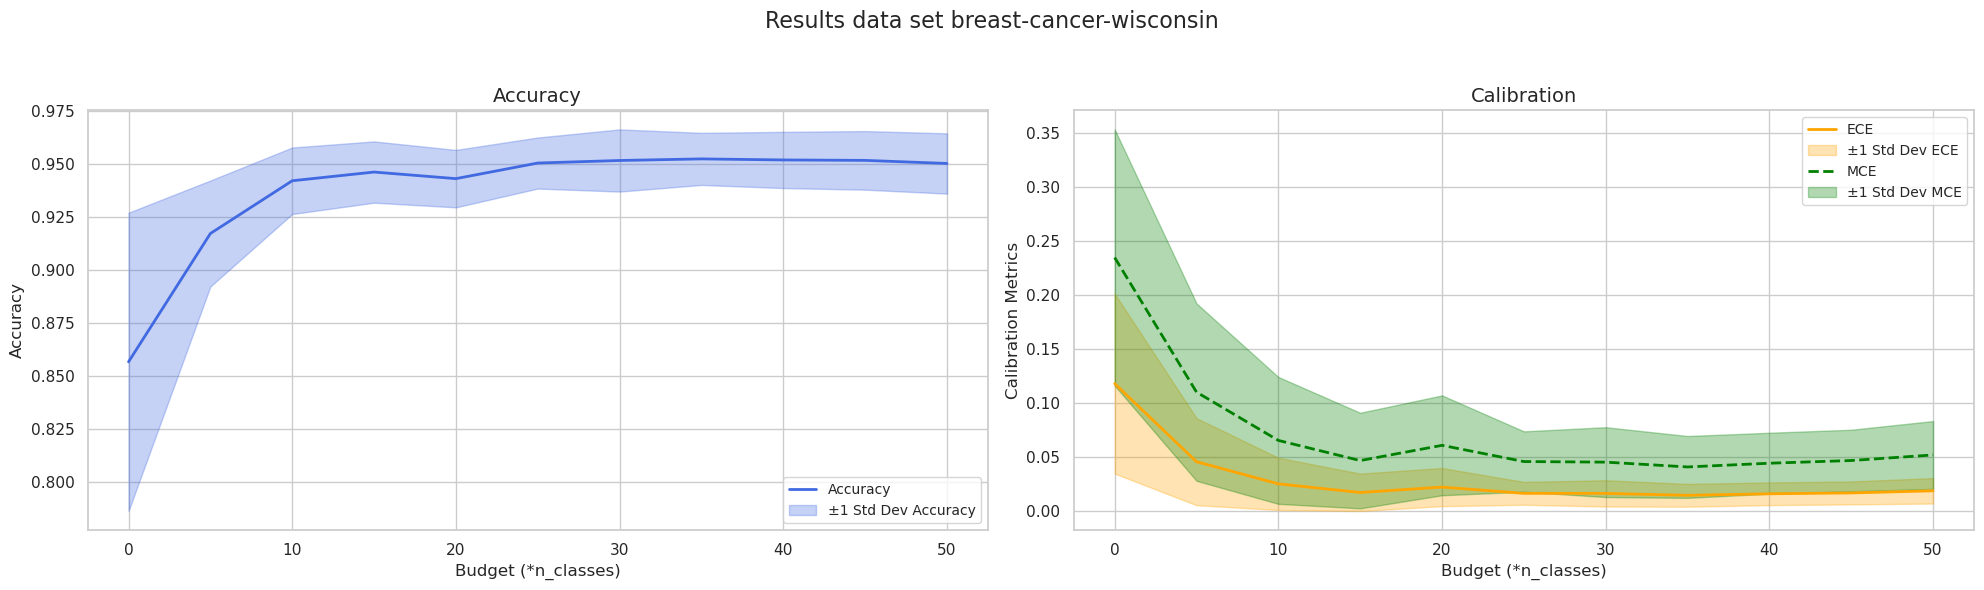

blood-transfusion


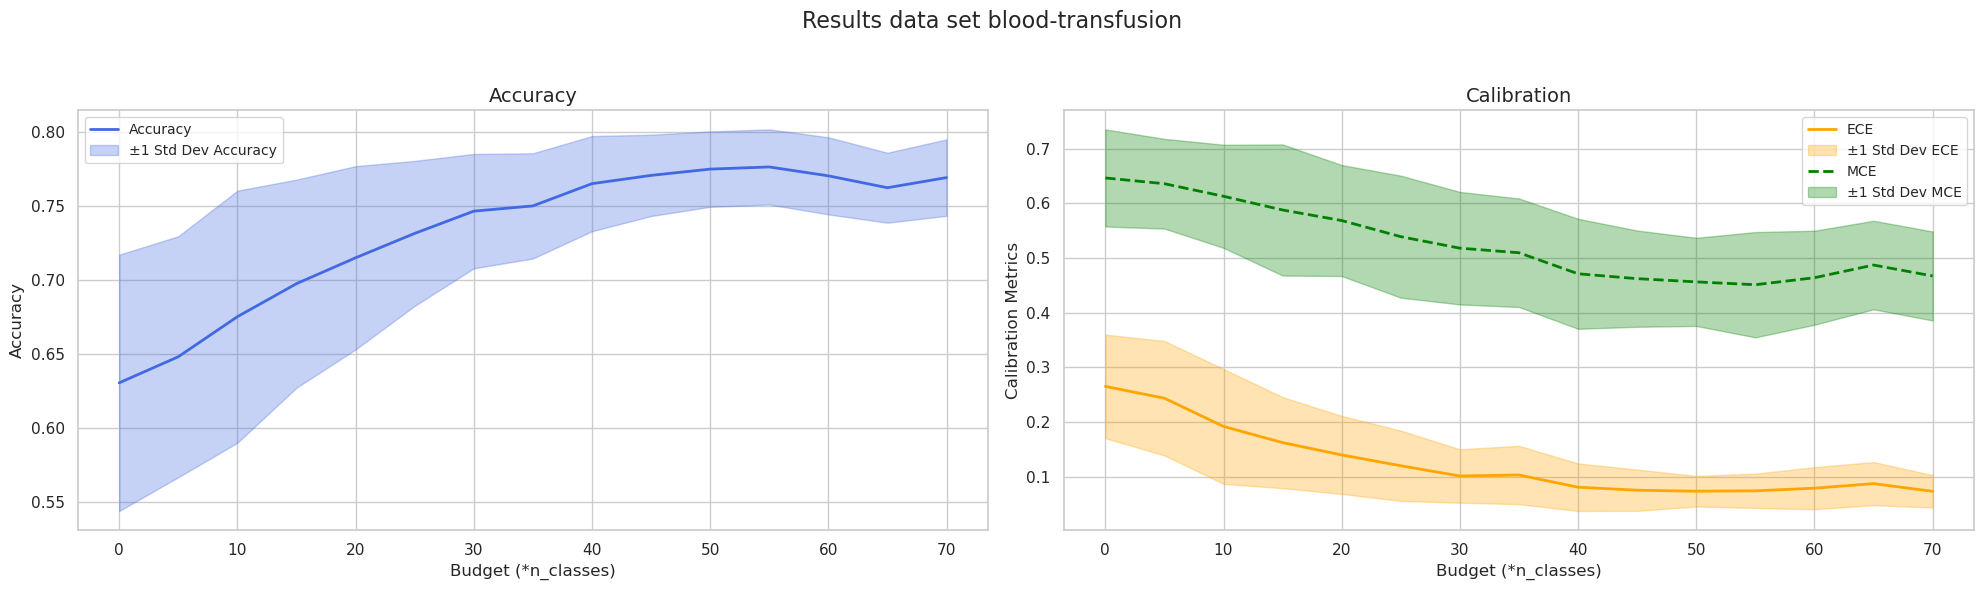

pima-indians-diabetes


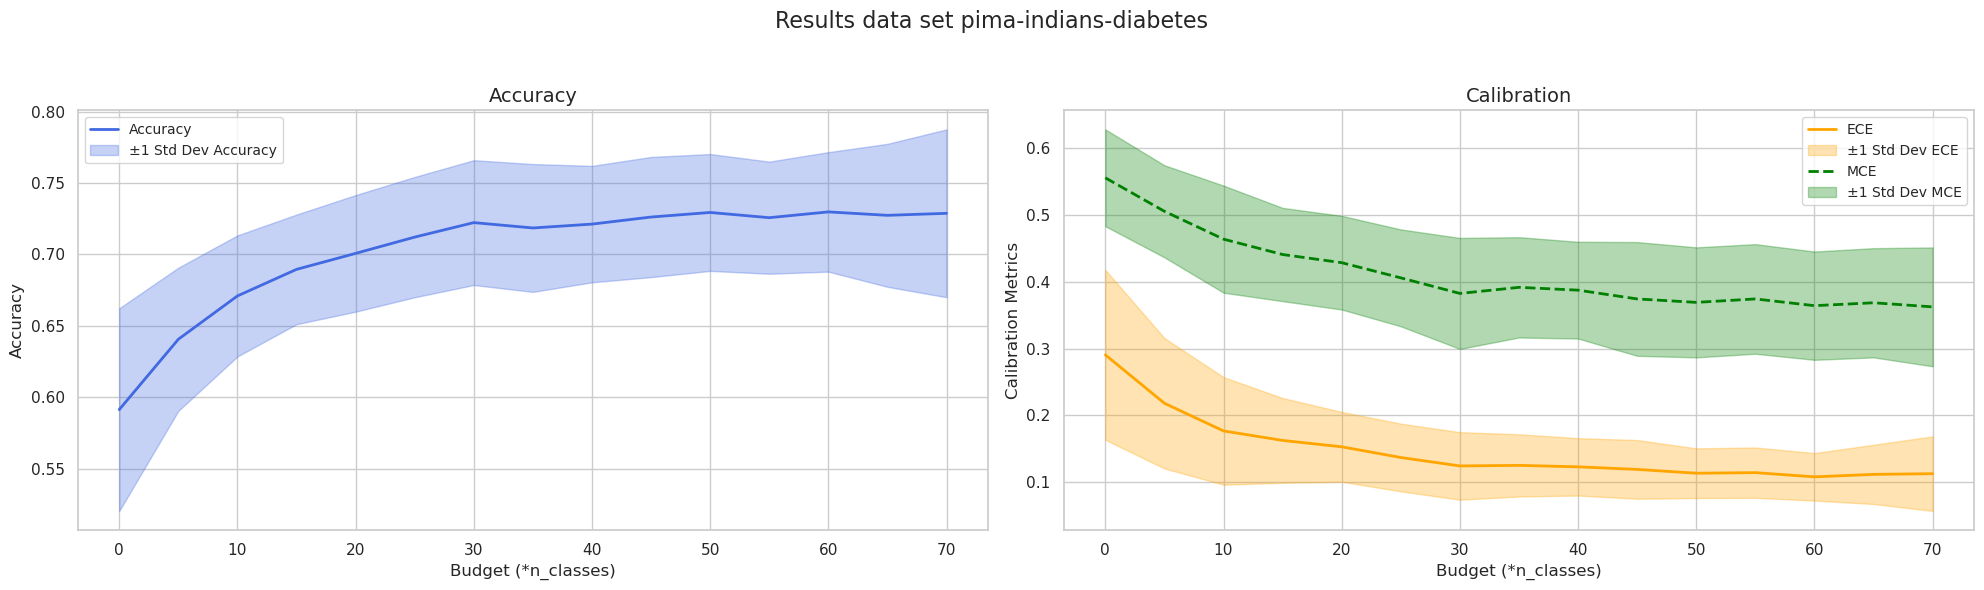

ionosphere


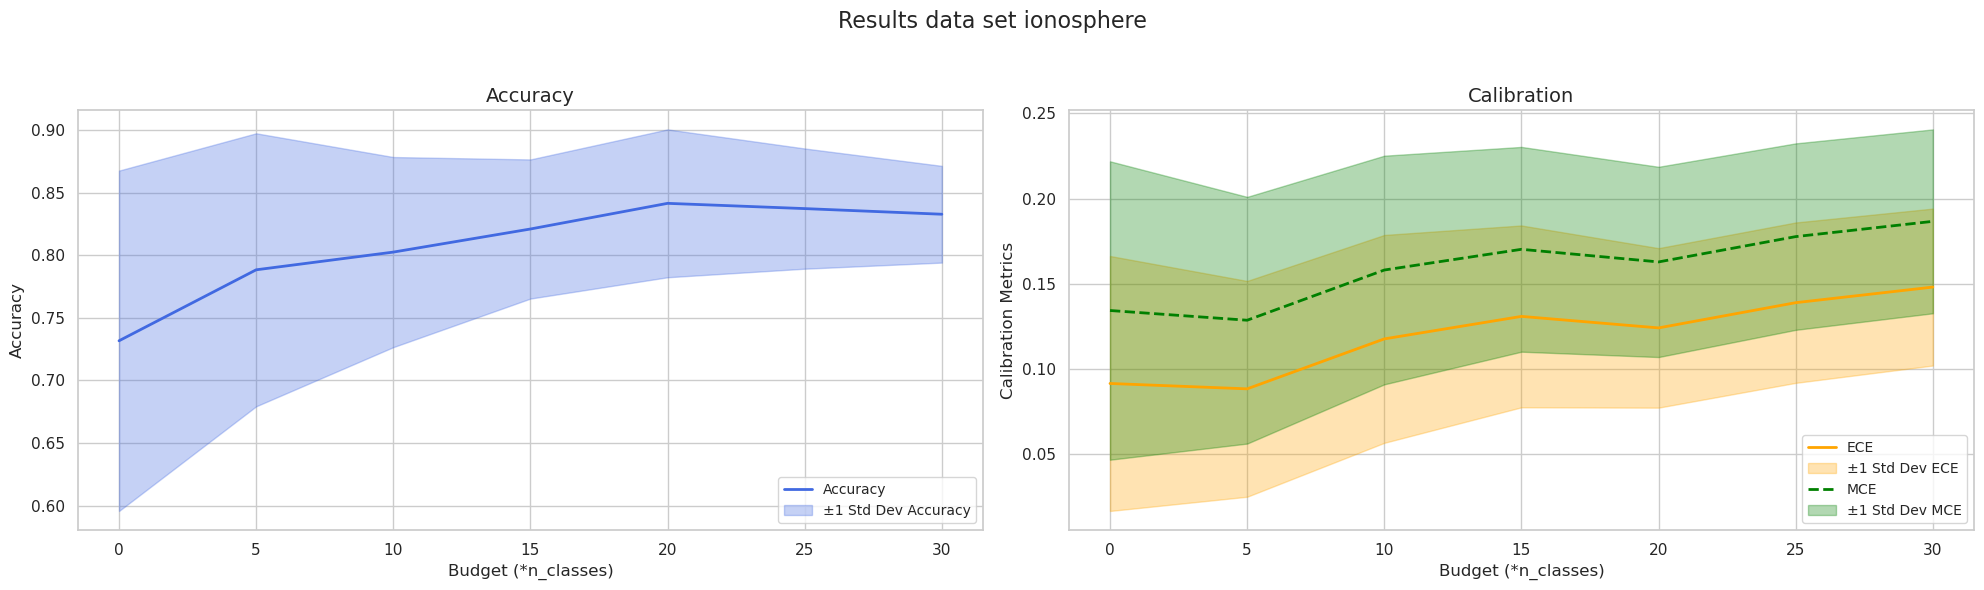

sonar


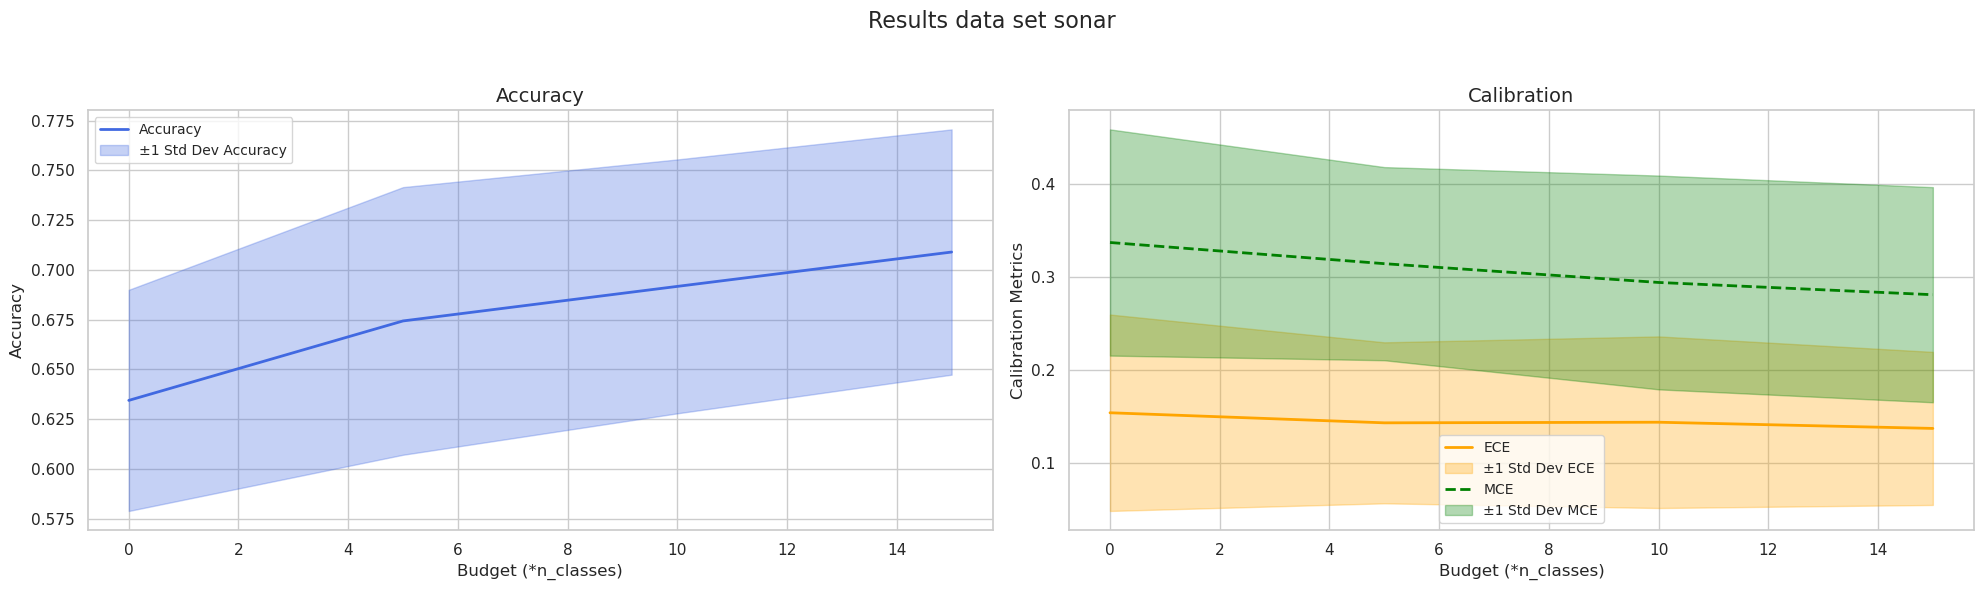

biodegradation


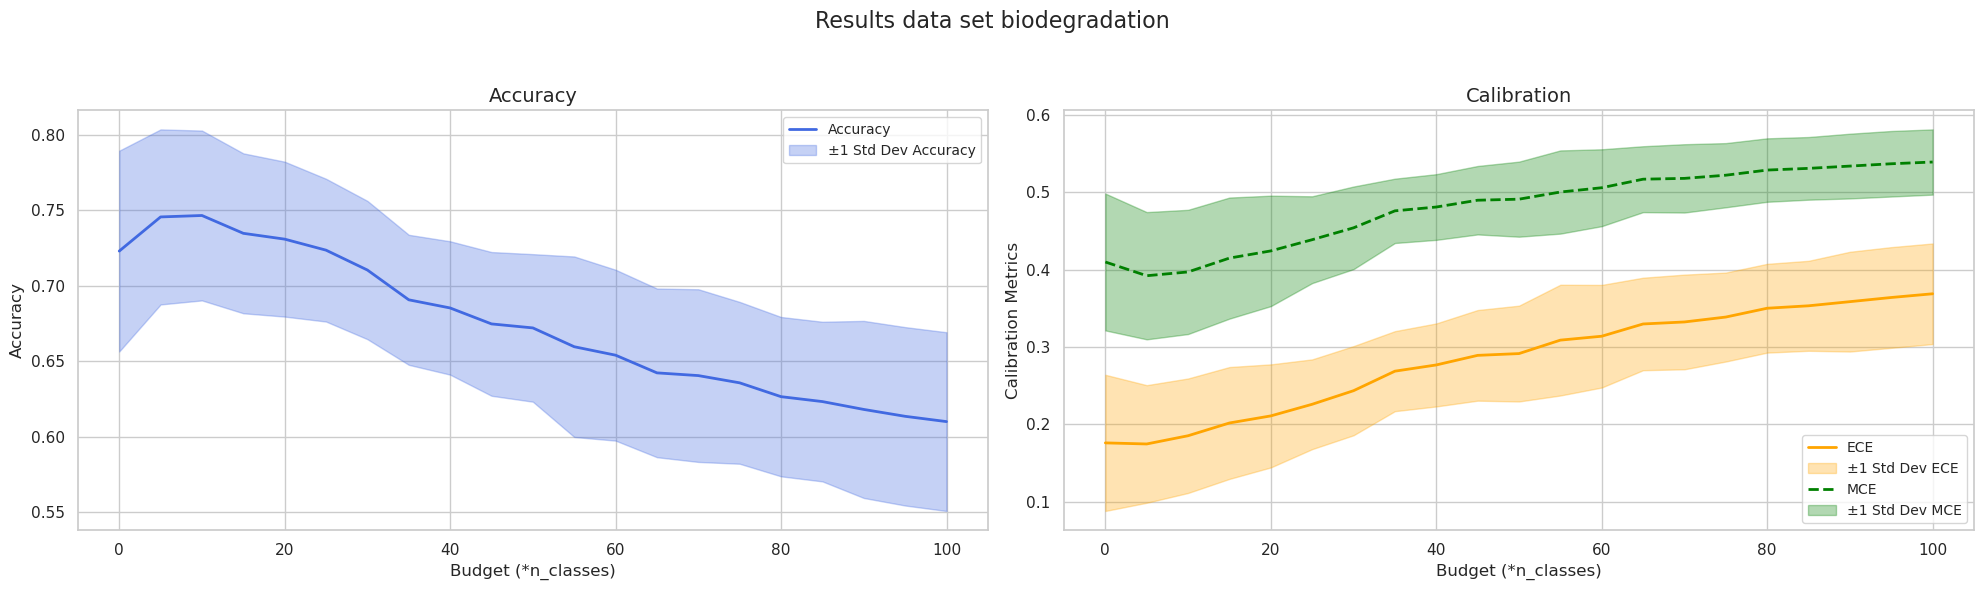

vehicle


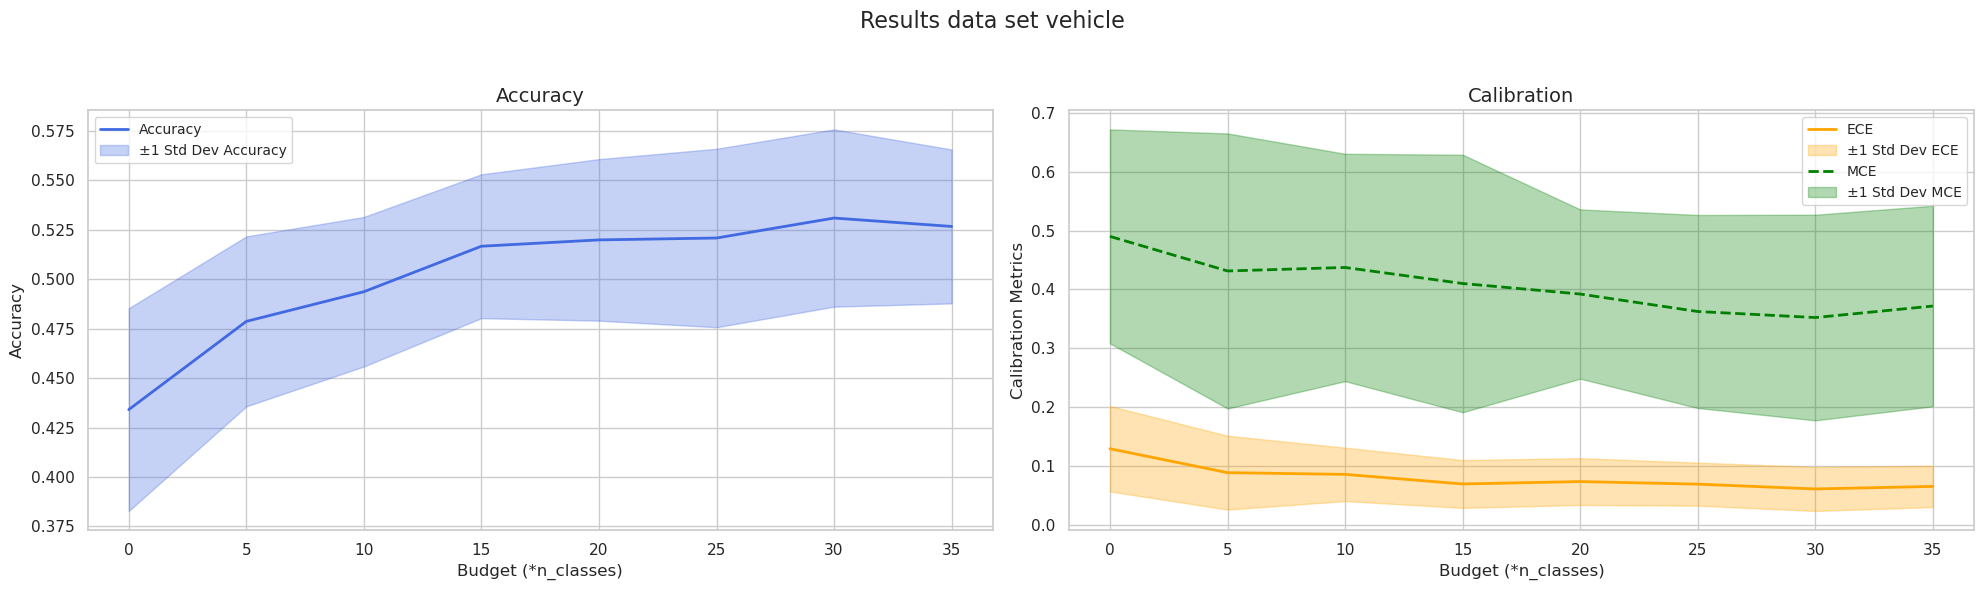

glass


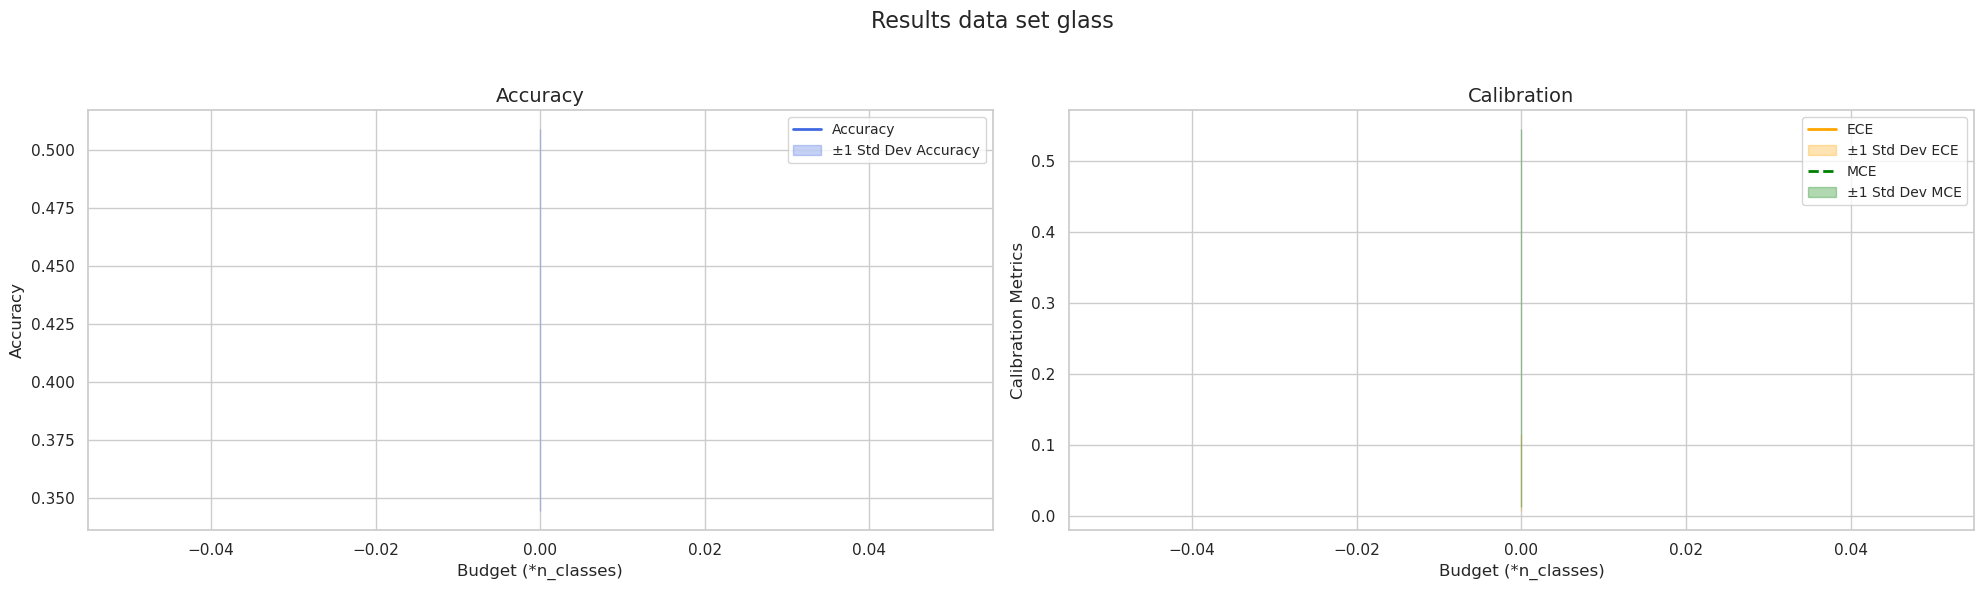

vertebra-column


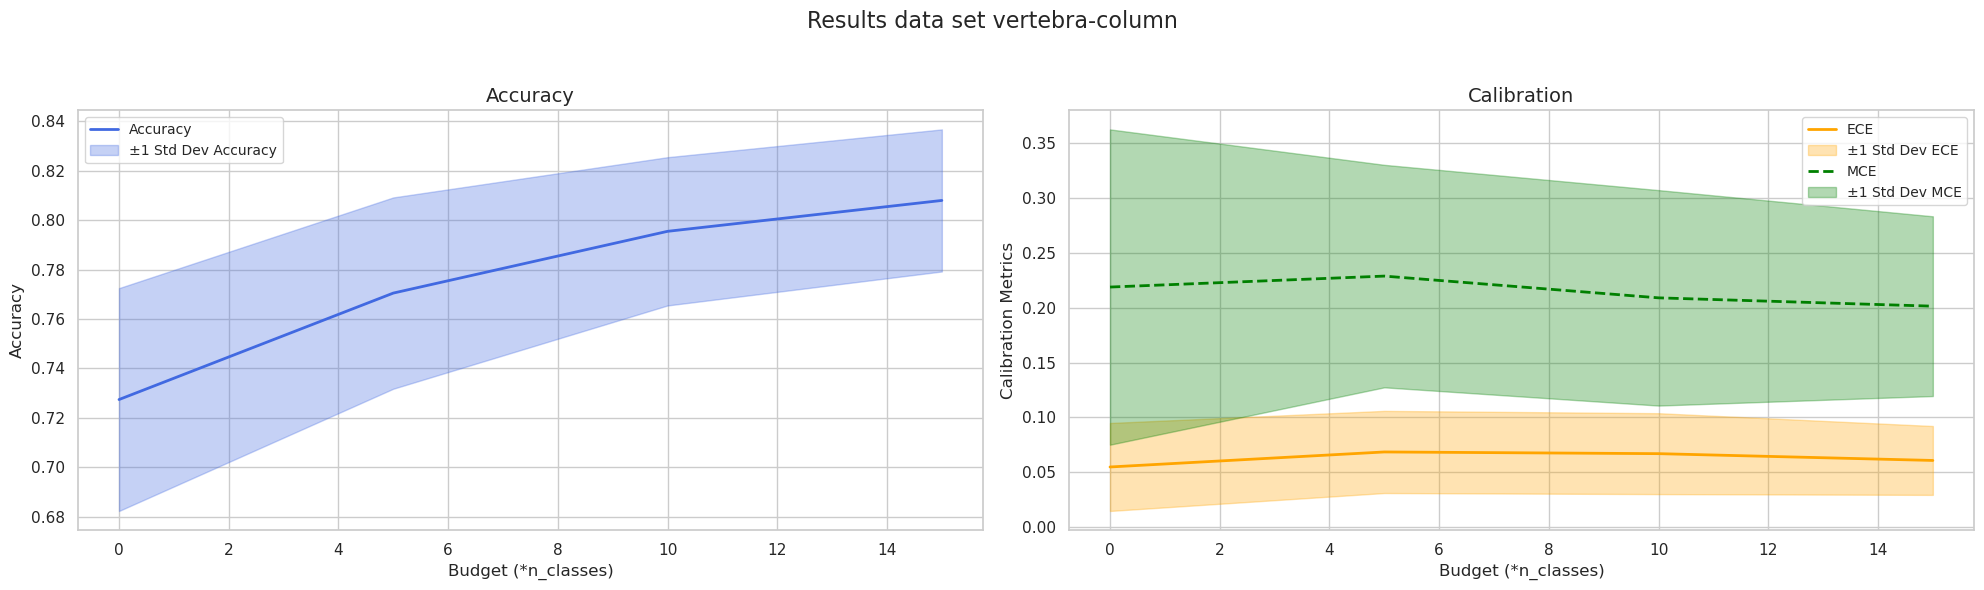

user-knowledge


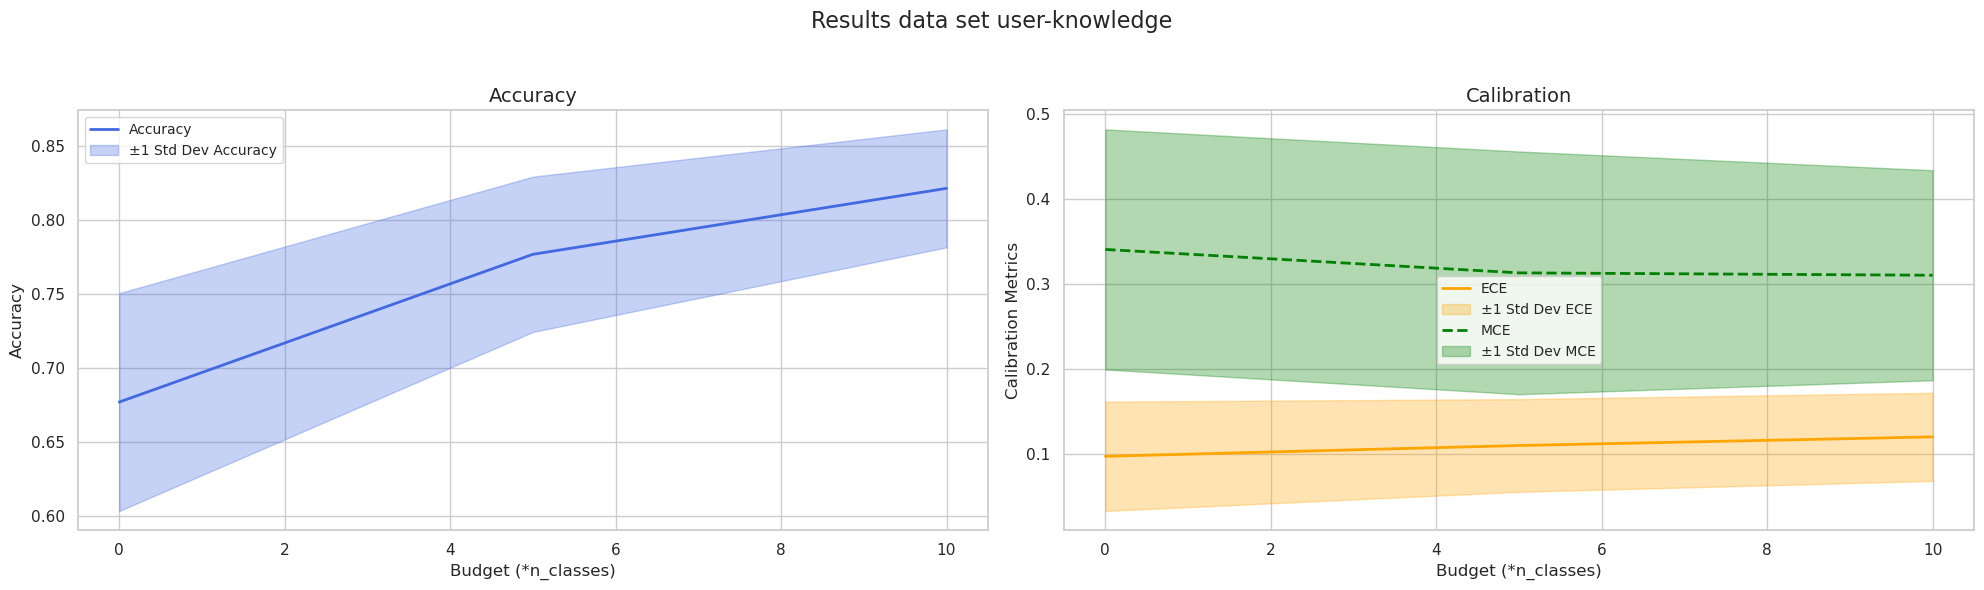

kc2


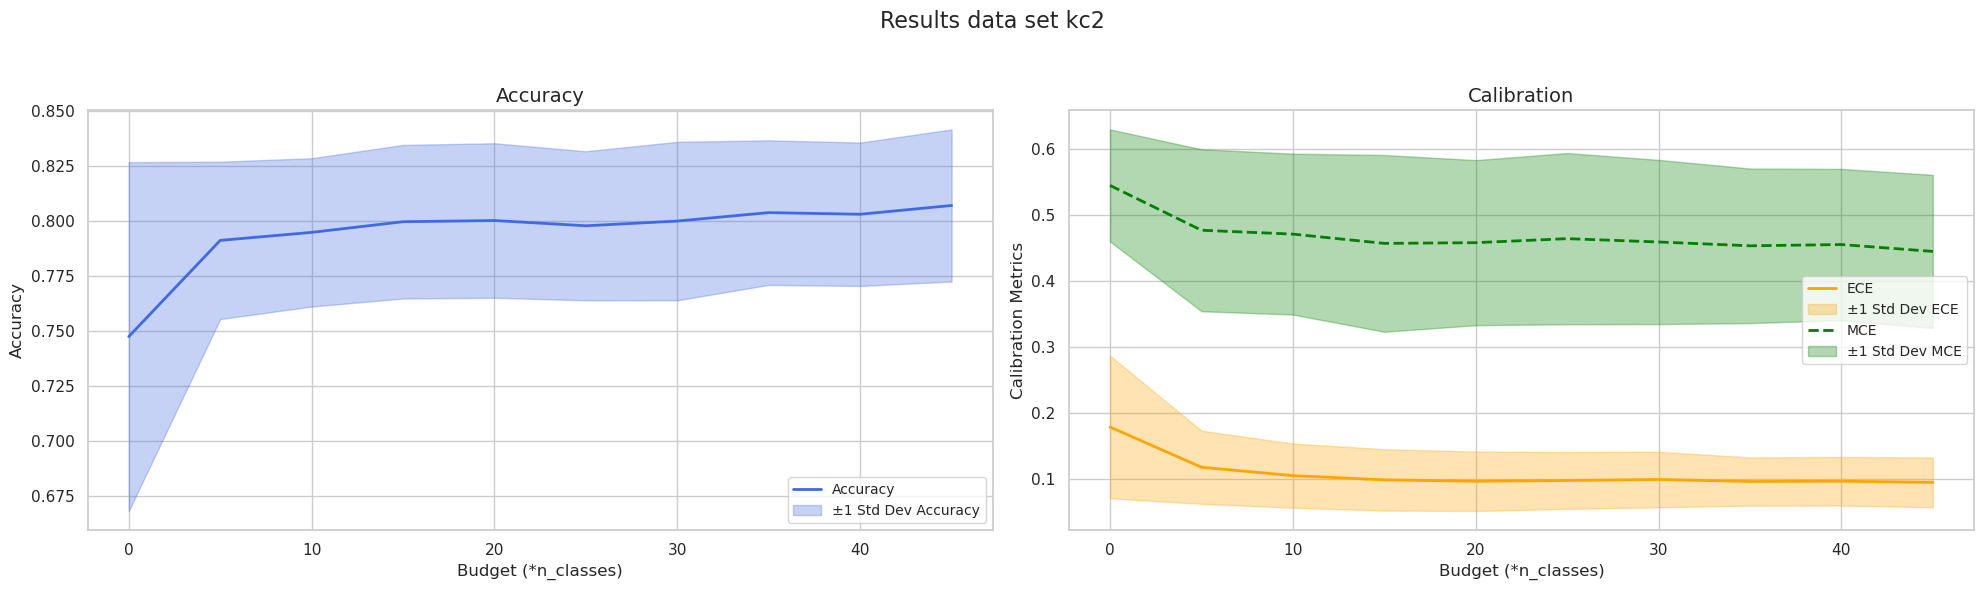

parkinsons


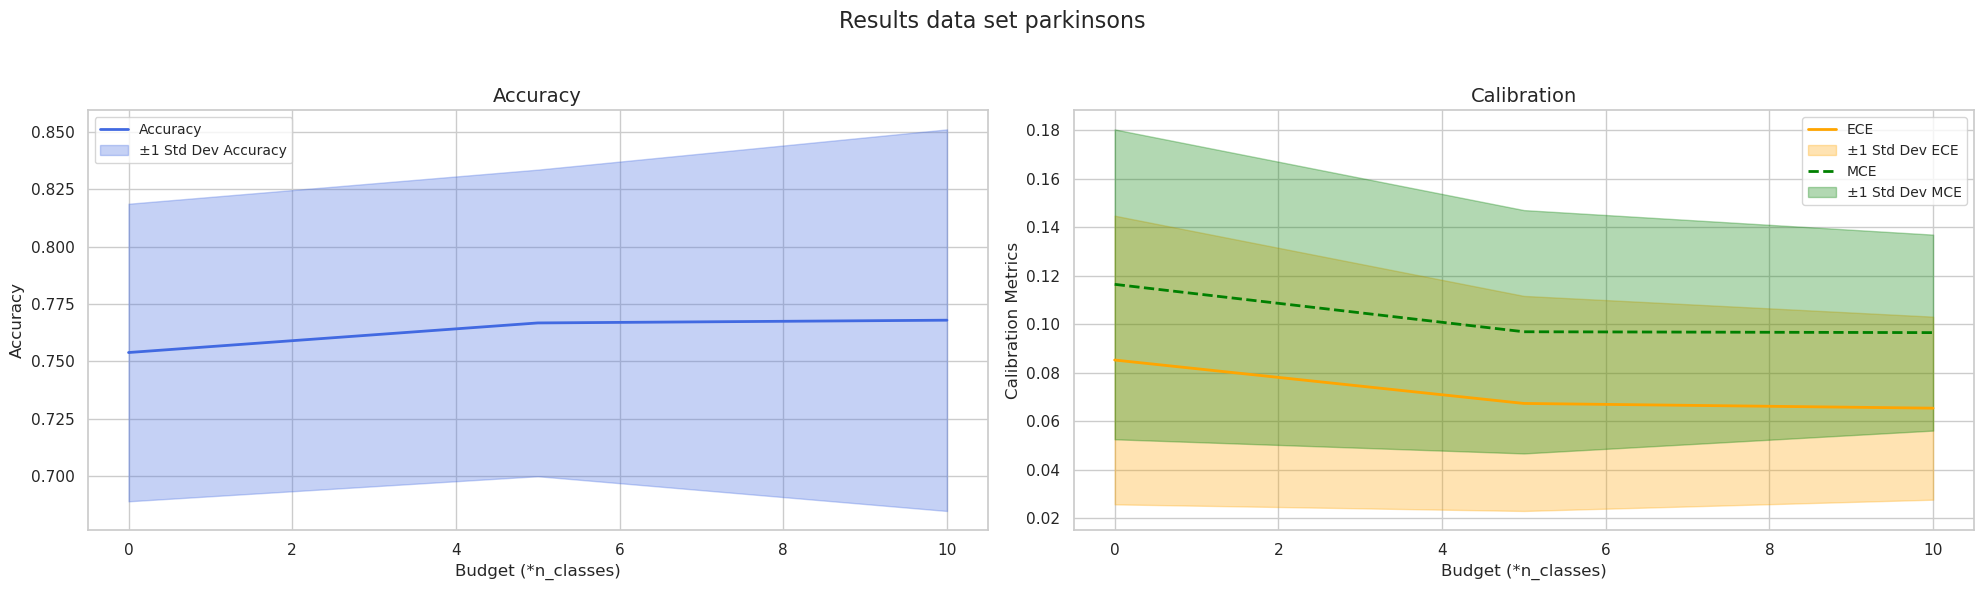

banknote


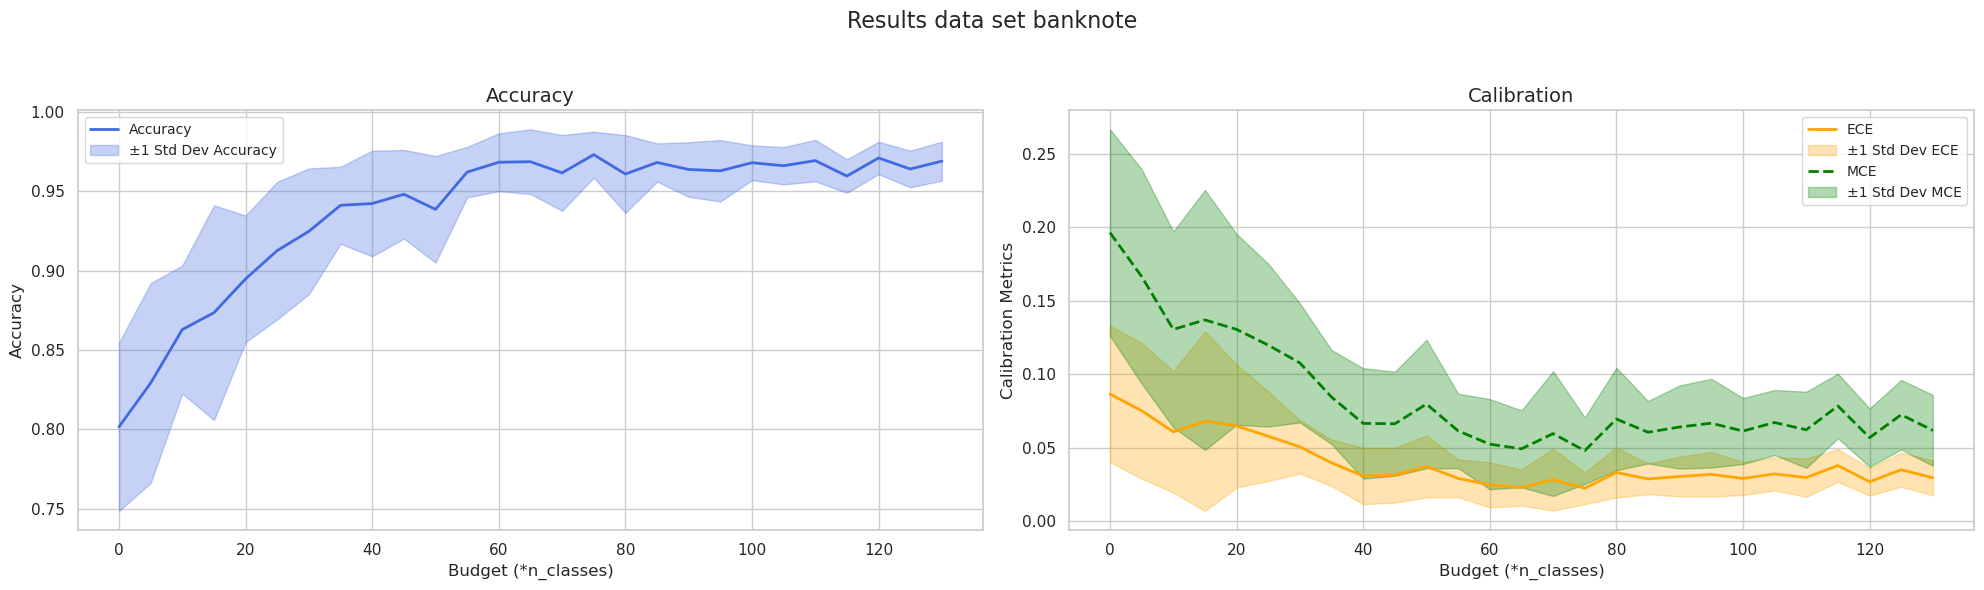

seeds


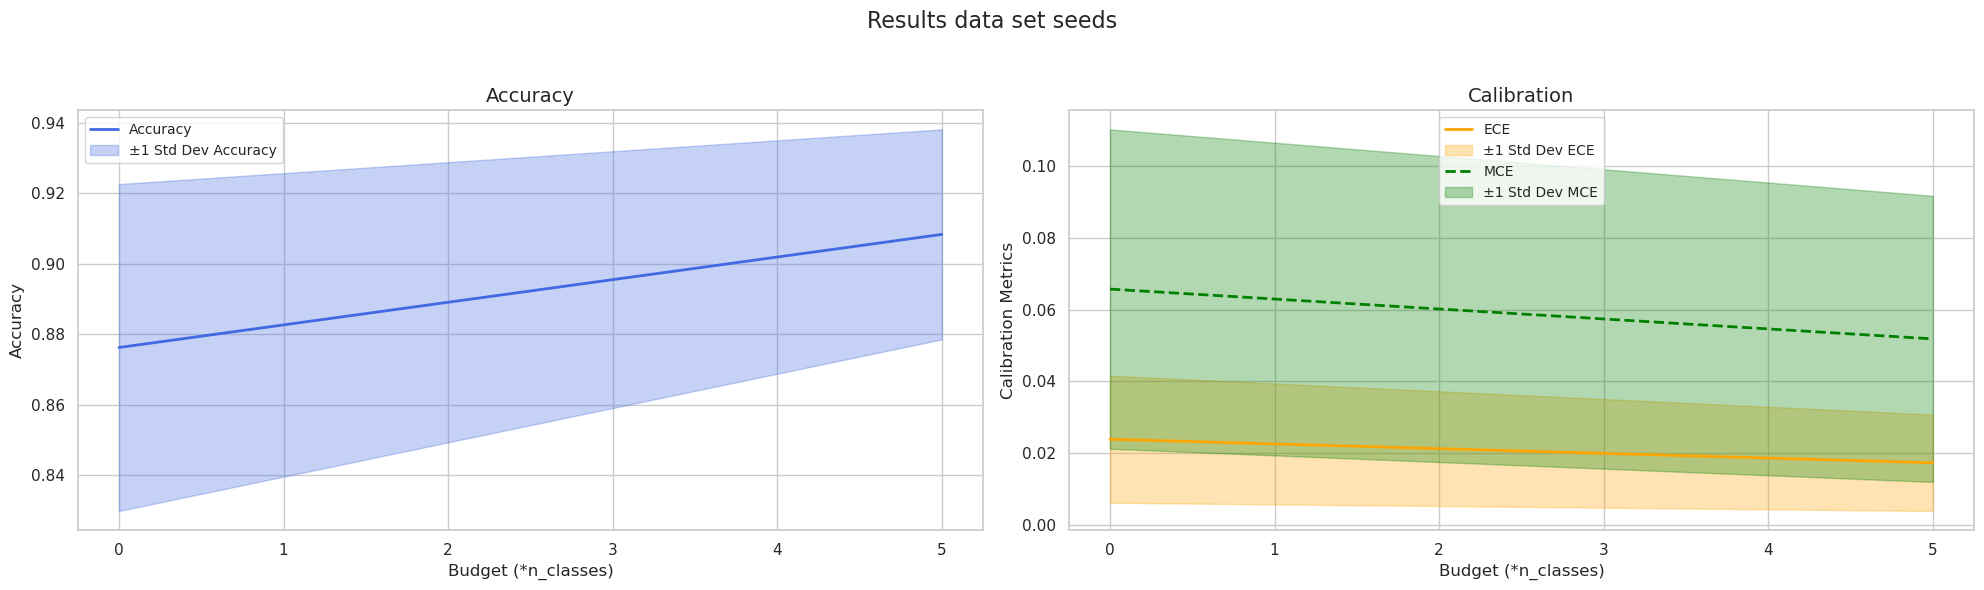

prnn-craps


/home/nico/lmu/active_learning/multi_annotator/data_functions.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = LabelEncoder().fit_transform(X[col])
/home/nico/lmu/active_learning/multi_annotator/data_functions.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = LabelEncoder().fit_transform(X[col])
/home/nico/lmu/active_learning/multi_annotator/data_functions.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

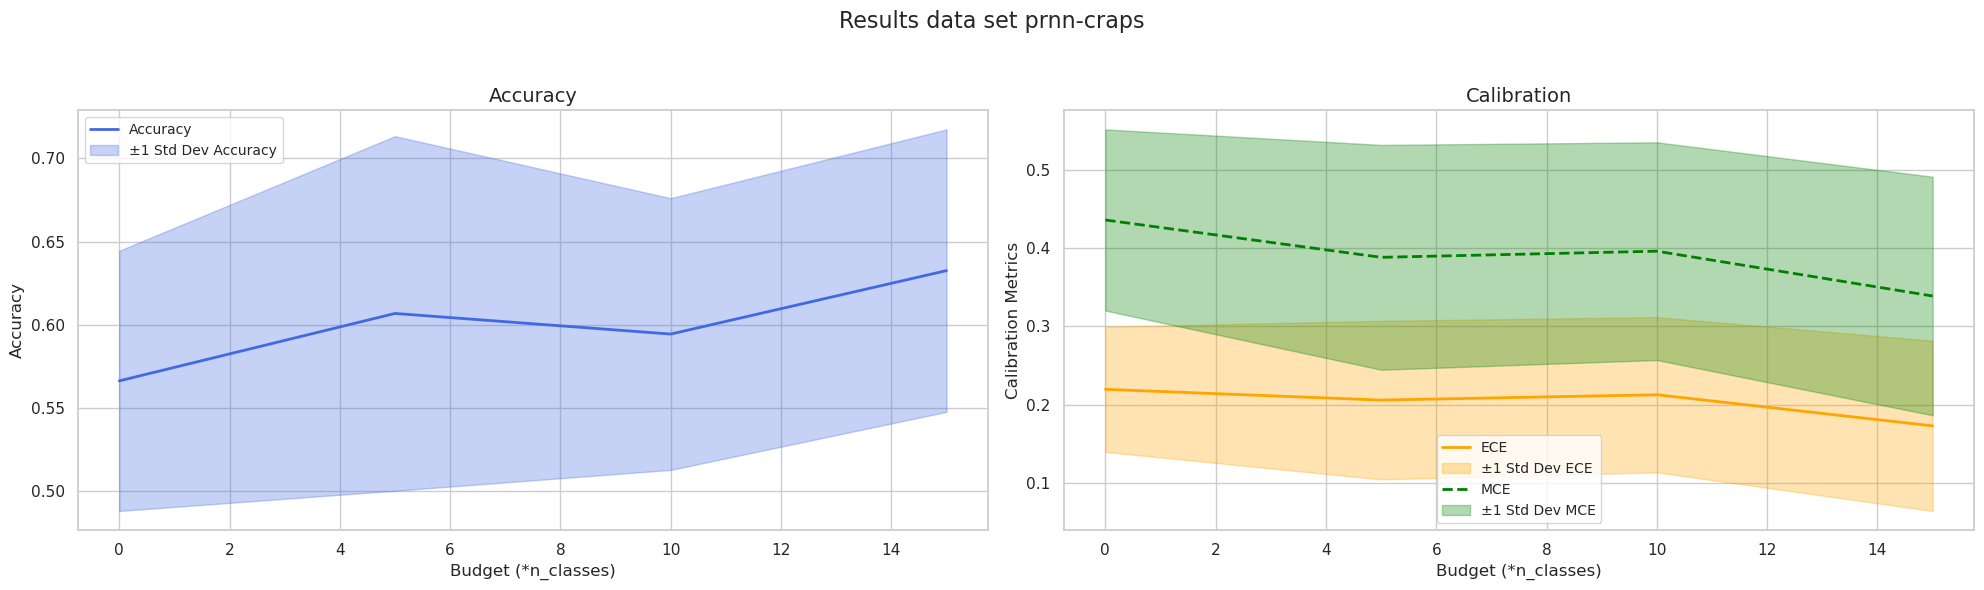

chscase-vine


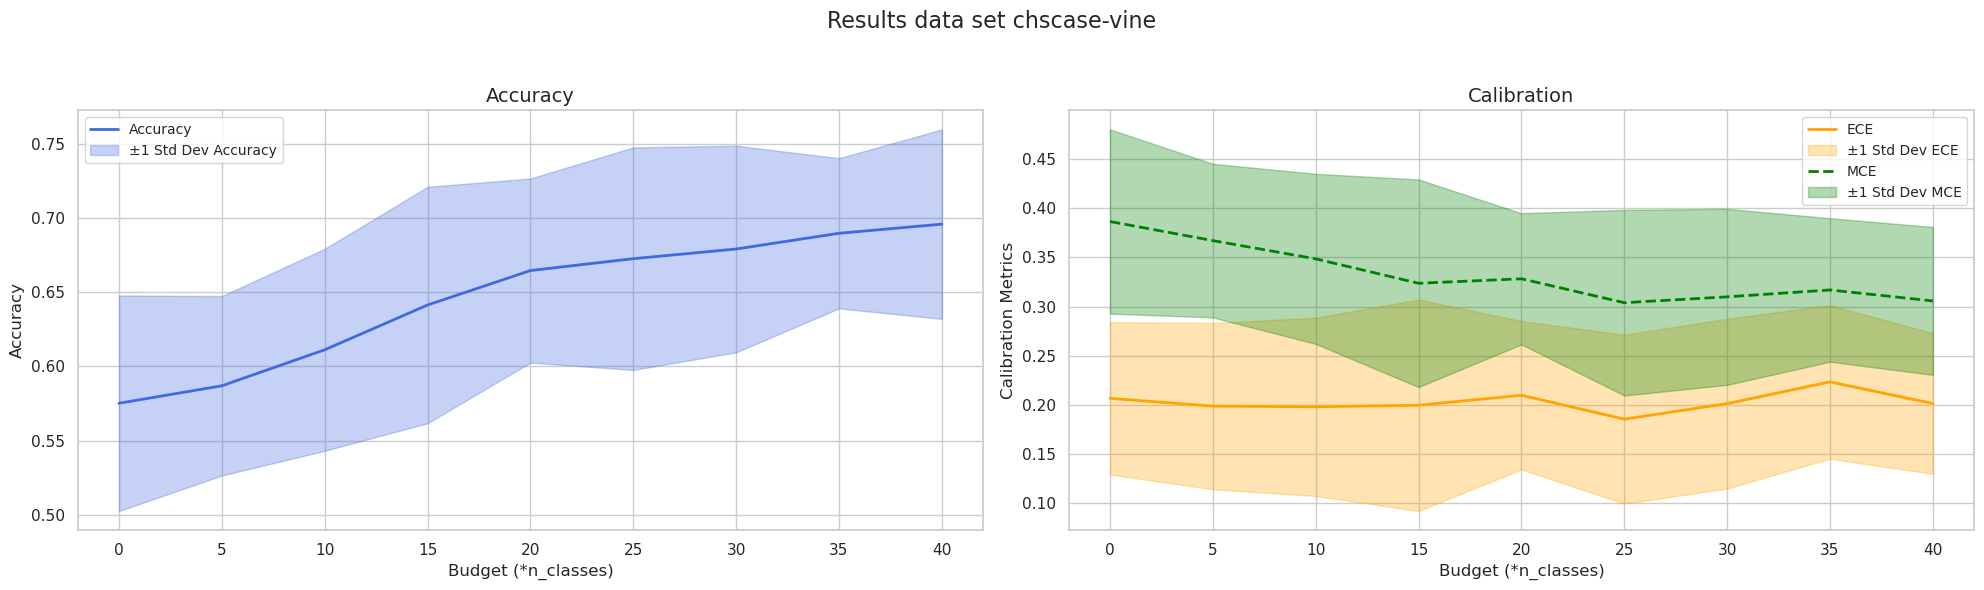

wine


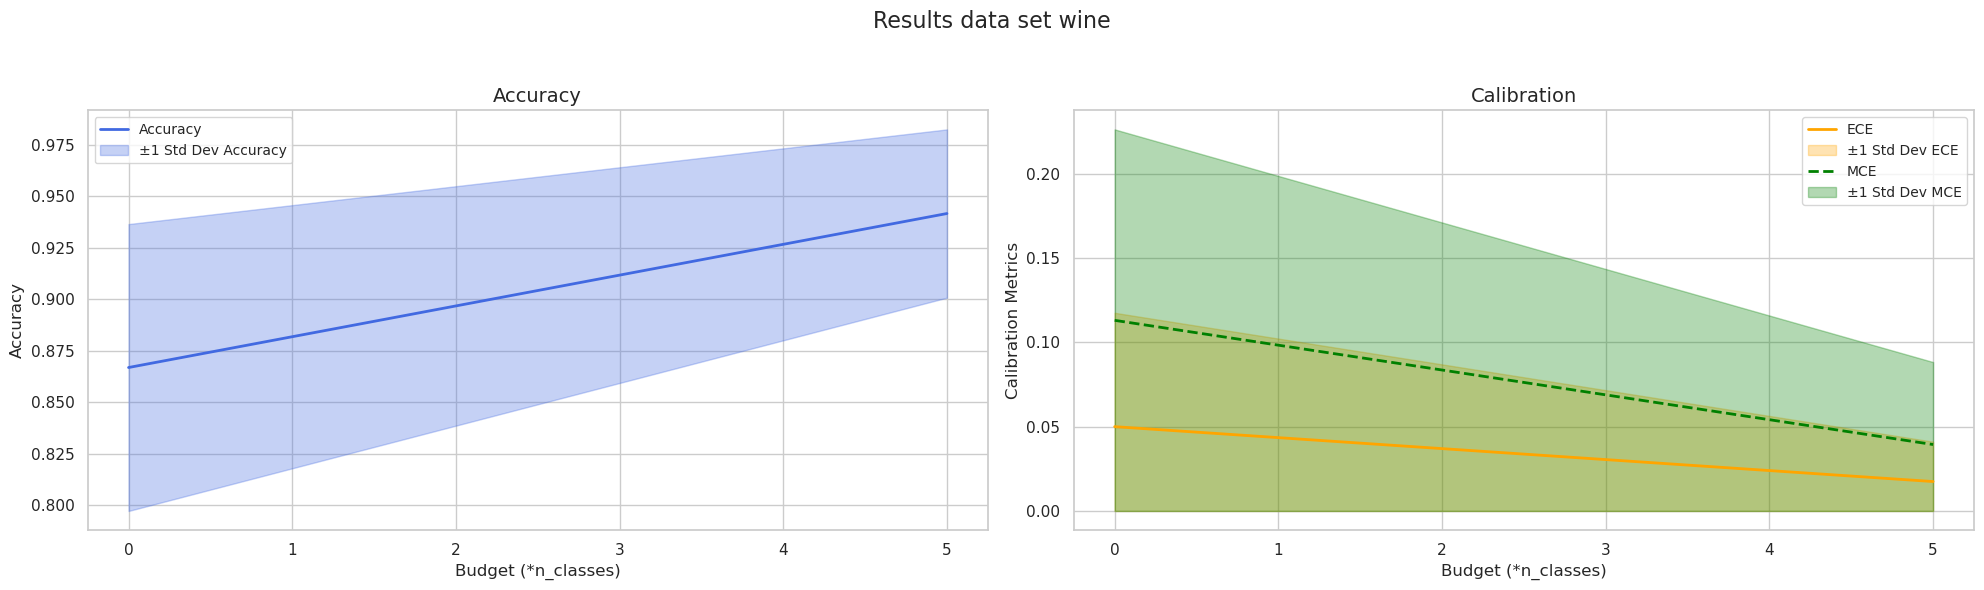

iris


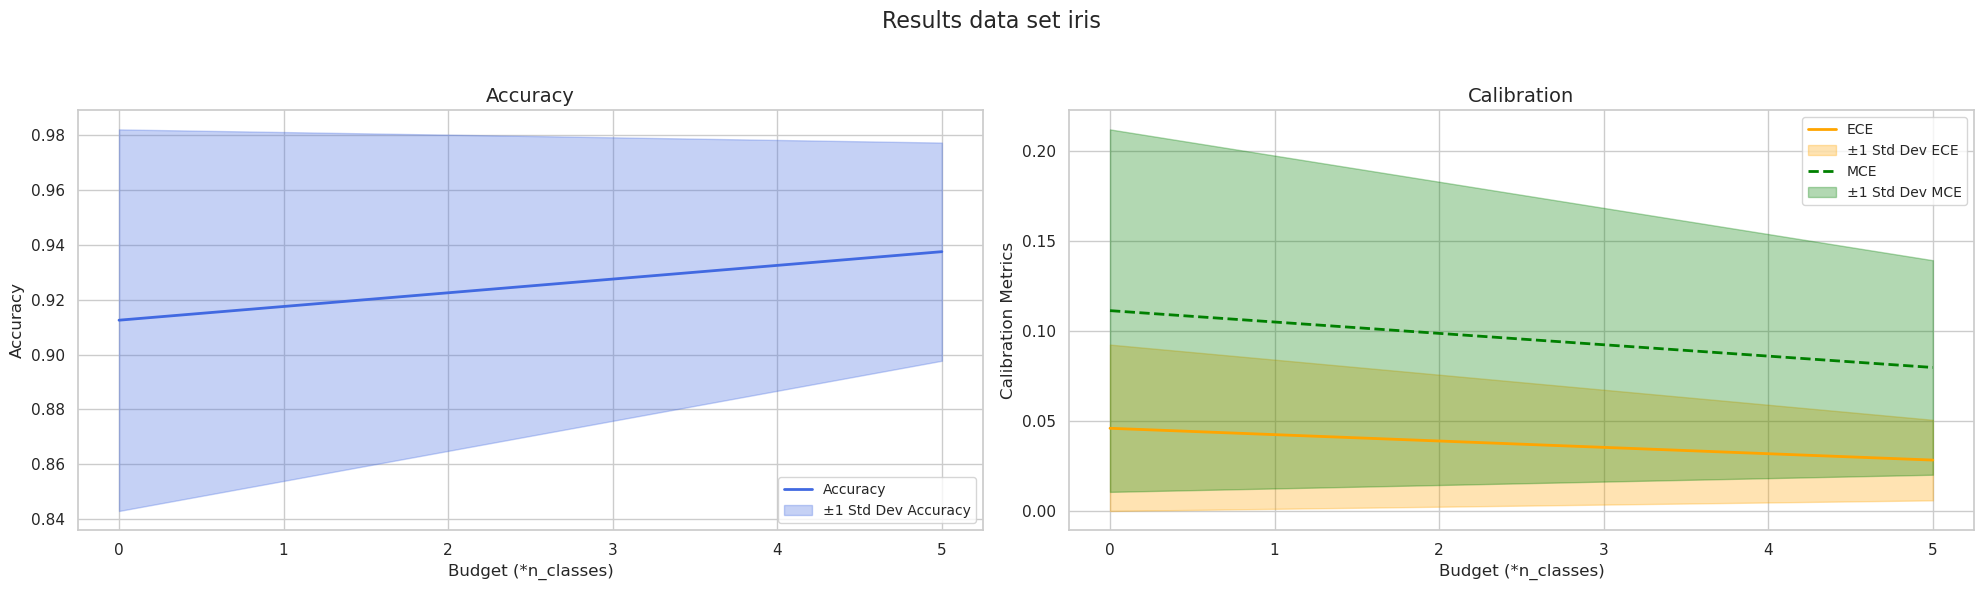

segment


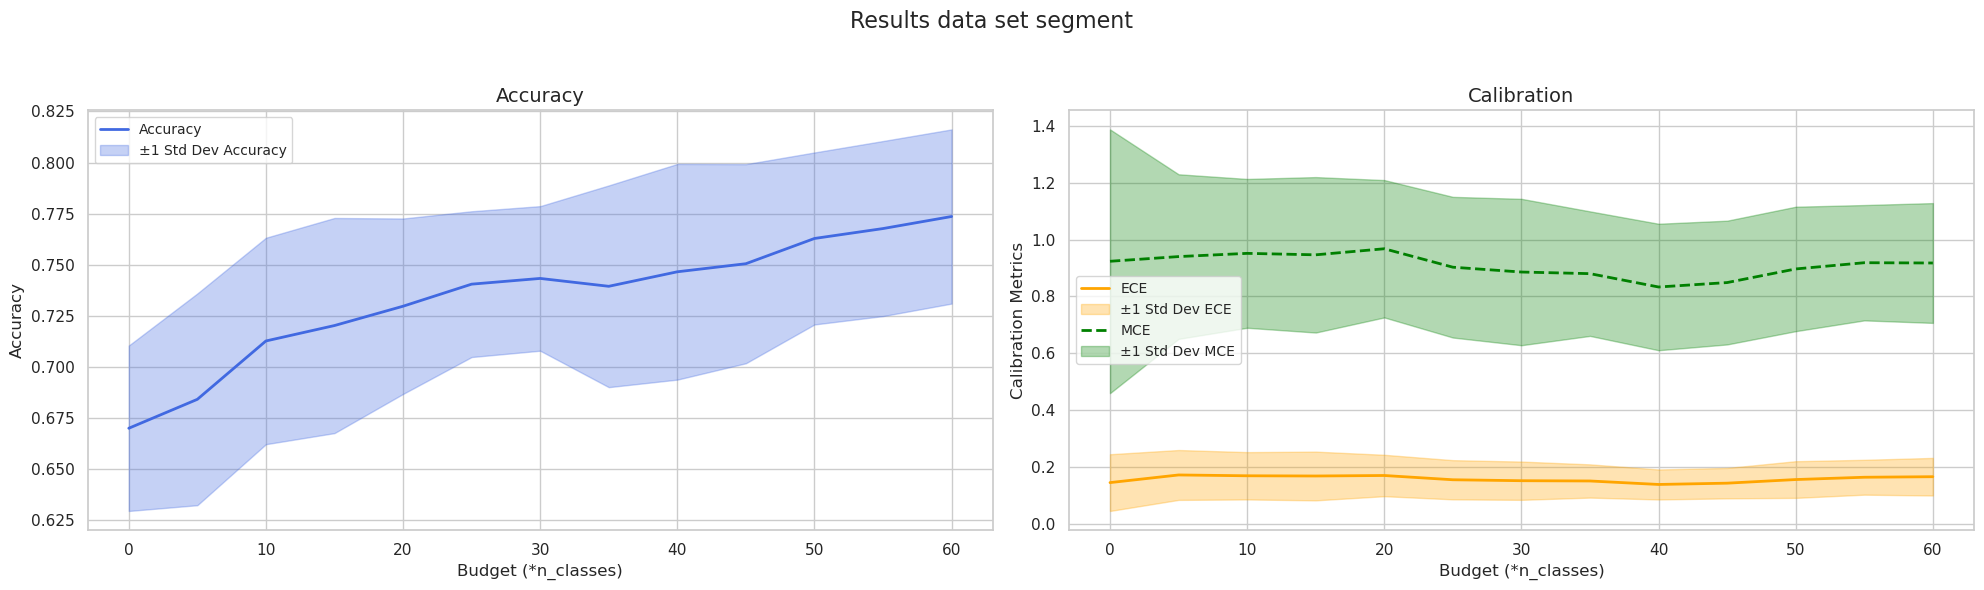

balance-scale


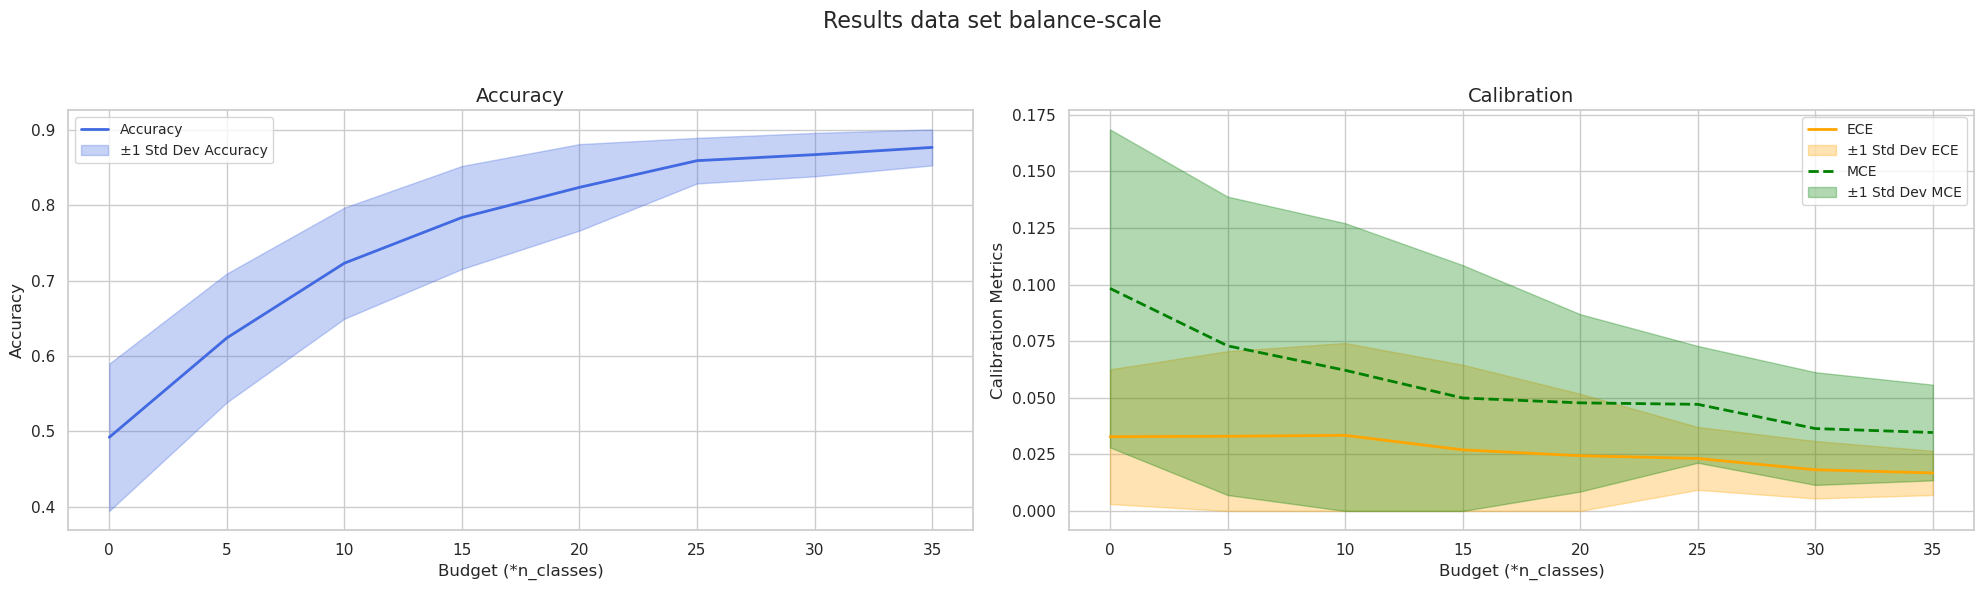

seismic-bumps


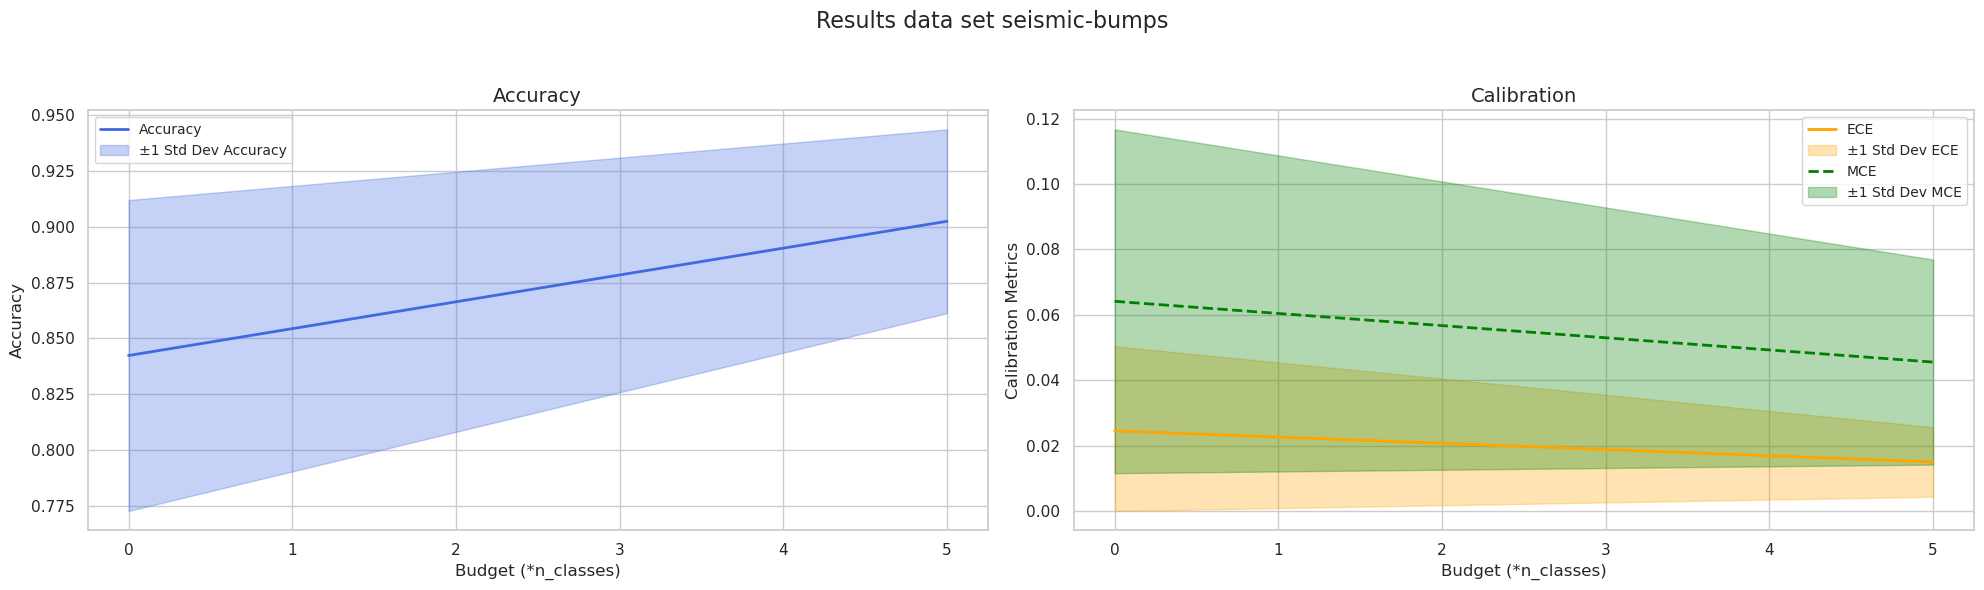

steel-plates-fault


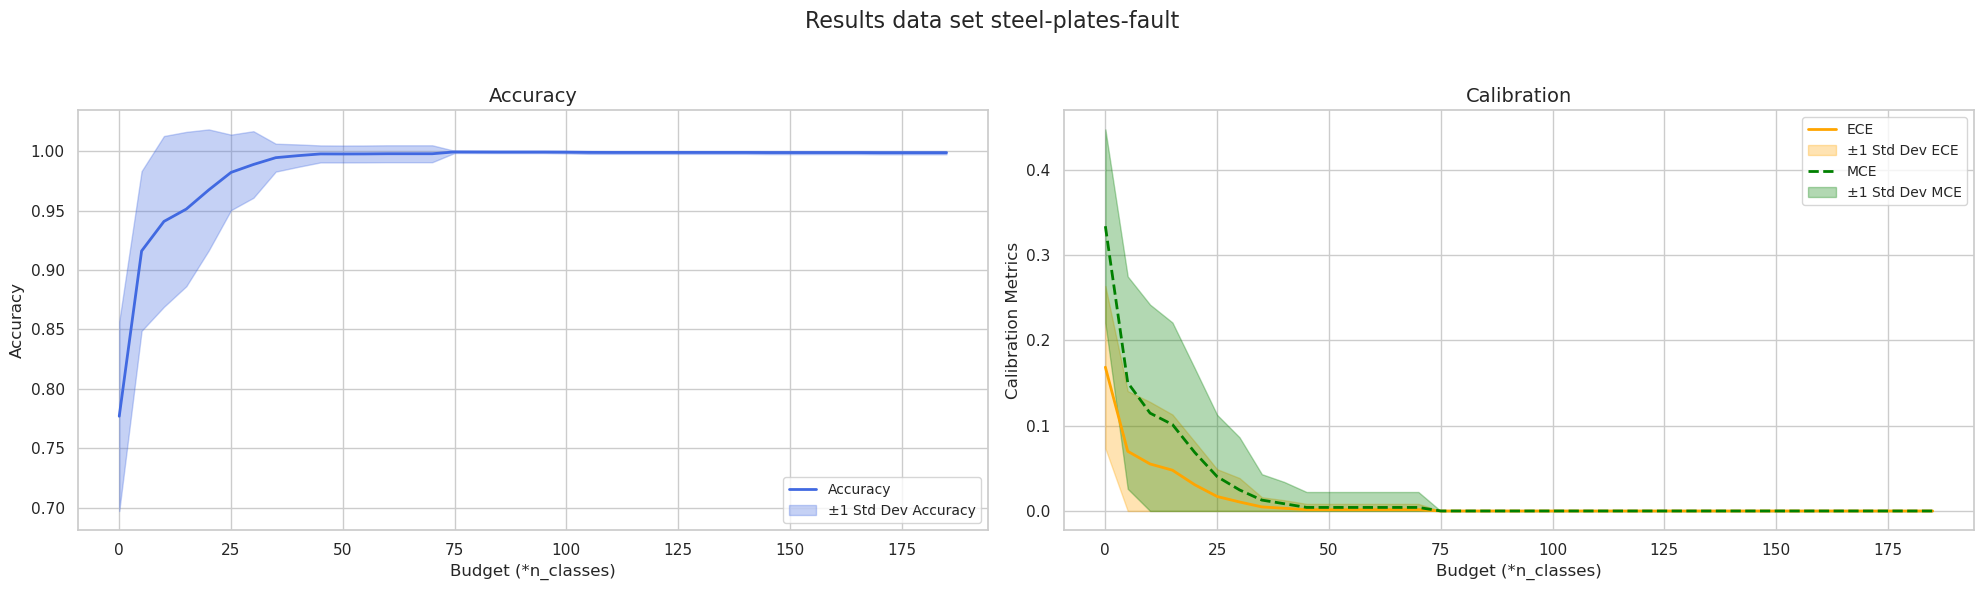

phoneme


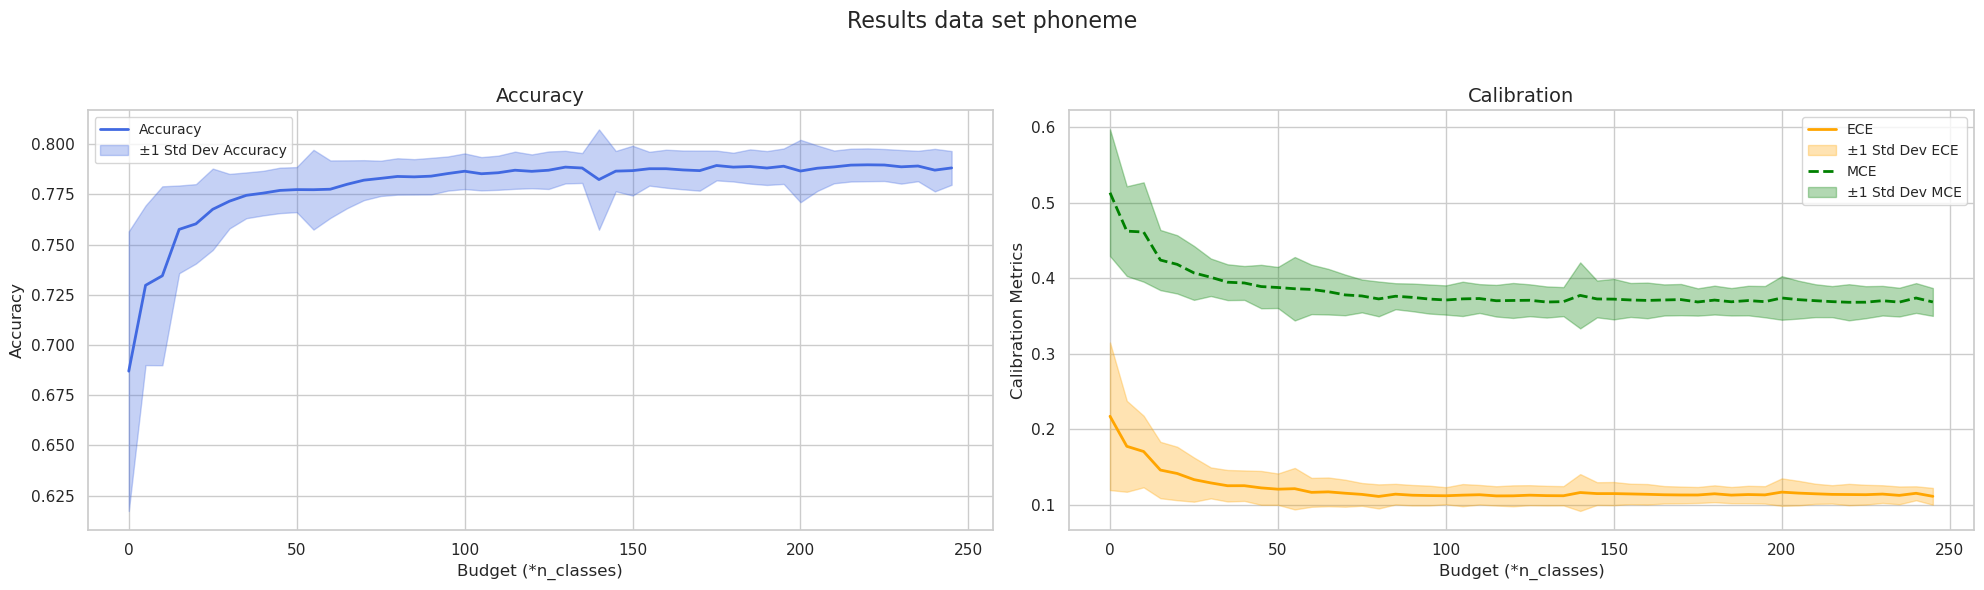

satimage


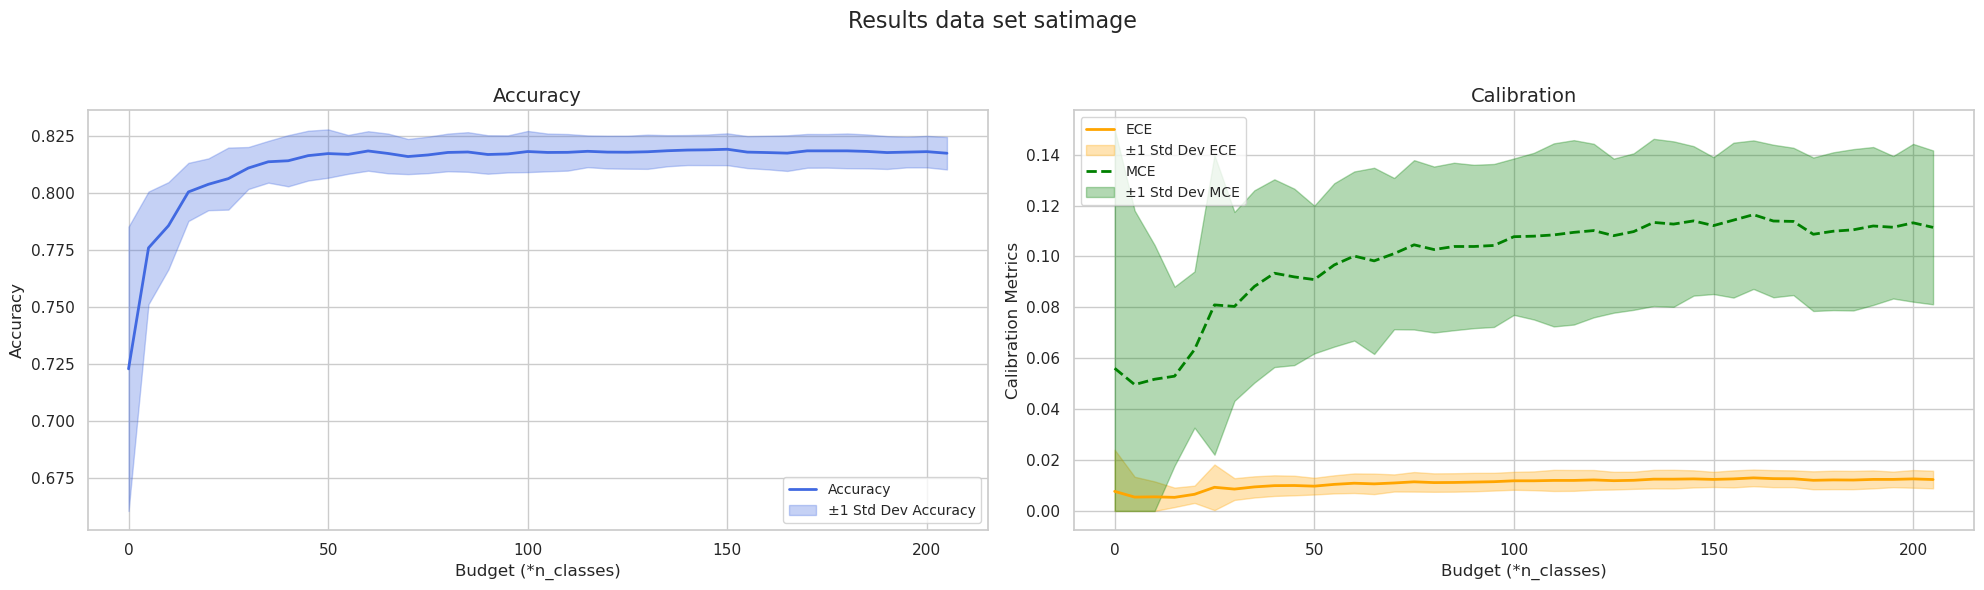

wind


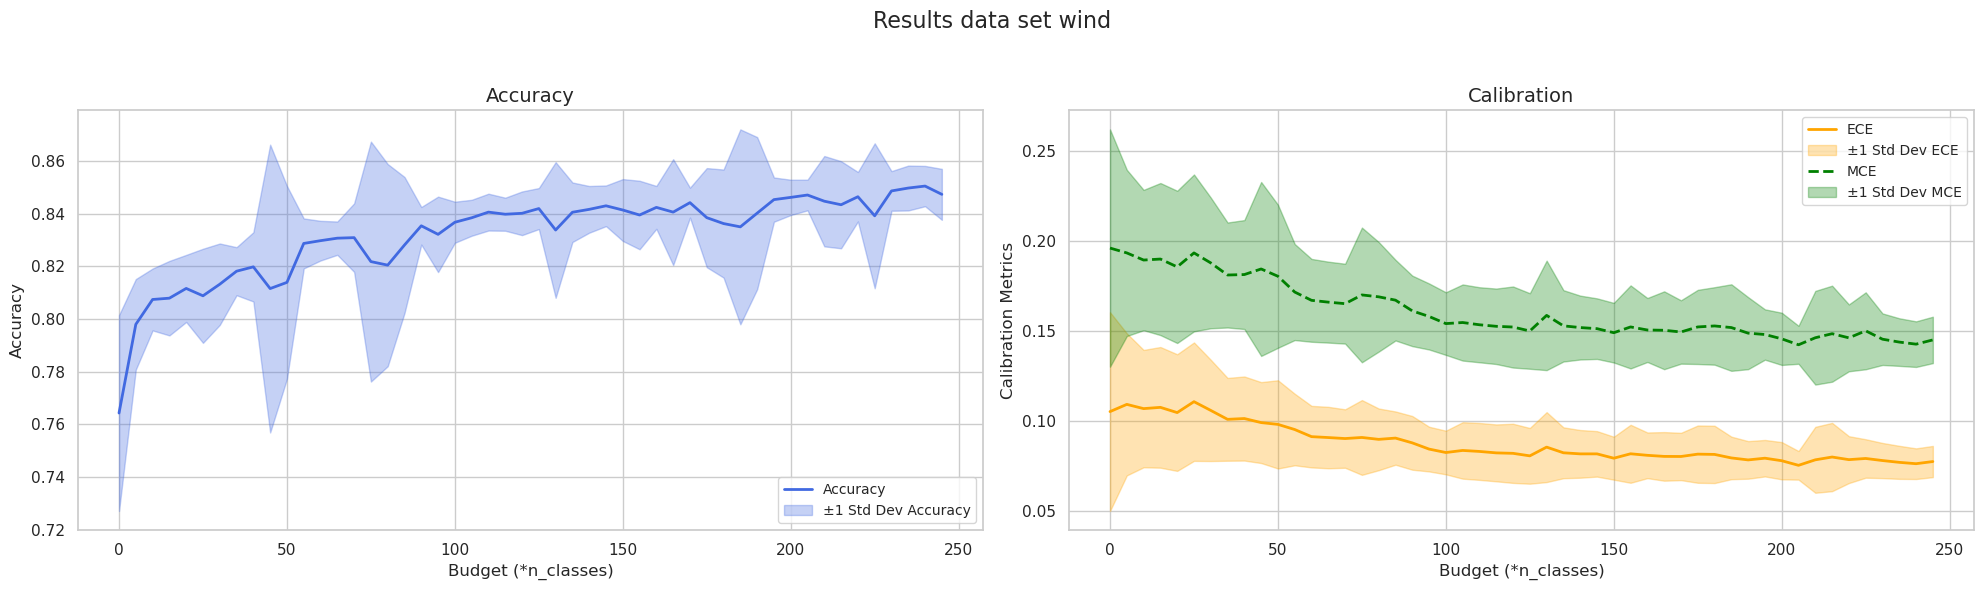

In [134]:
skip = ['ecoli']

for data_set_name in data_set_names:

	if data_set_name in skip: continue

	print(data_set_name)	
	# Experiment details
	seeds = np.arange(20)
	nbudget = 5

	results = []

	for seed in seeds:
		res = run_experiment(classifier=GaussianNB, nbudget=nbudget, query_strategy=margin_qs, data_set_name=data_set_name, seed=seed, verbose=False)
		results.append(res)

	# Extract accuracy, ECE, and MCE data
	acc = [x['accuracies'] for x in results]
	ece = [x['ece'] for x in results]
	mce = [x['mce'] for x in results]

	x = np.arange(len(acc[0])) * nbudget  # Budget values
	sns.set_theme(style='whitegrid')  # Use modern Seaborn styling

	# Create subplots
	fig, axes = plt.subplots(1, 2, figsize=(20, 6))

	# Plot accuracy on the left
	plot_mean_std(axes[0], acc, x, label="Accuracy", color="royalblue")
	axes[0].set_title("Accuracy", fontsize=14)
	axes[0].set_xlabel("Budget (*n_classes)", fontsize=12)
	axes[0].set_ylabel("Accuracy", fontsize=12)
	axes[0].legend(fontsize=10)

	# Plot ECE and MCE on the right
	plot_mean_std(axes[1], ece, x, label="ECE", color="orange")
	plot_mean_std(axes[1], mce, x, label="MCE", color="green", linestyle='--')
	axes[1].set_title("Calibration", fontsize=14)
	axes[1].set_xlabel("Budget (*n_classes)", fontsize=12)
	axes[1].set_ylabel("Calibration Metrics", fontsize=12)
	axes[1].legend(fontsize=10)

	# Set the overall title
	fig.suptitle(f"Results data set {data_set_name}", fontsize=16)

	# Adjust layout
	plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the overall title

	# Show the plot
	plt.show()

In [122]:
res = run_experiment(classifier=GaussianNB, nbudget=5, query_strategy=margin_qs, data_set_name='ecoli', seed=0, verbose=True)
res

Iteration: 0. Accuracy: 0.77. MCE: 0.233. ECE: 0.052
Iteration: 1. Accuracy: 0.844. MCE: 0.458. ECE: 0.081
Iteration: 2. Accuracy: 0.874. MCE: 0.462. ECE: 0.089


{'accuracies': [0.77, 0.844, 0.874],
 'mce': [0.233, 0.458, 0.462],
 'ece': [0.052, 0.081, 0.089]}

0.6001000000000001


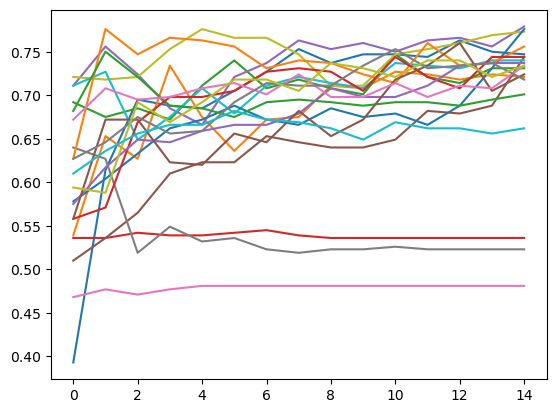

In [71]:
s = 0
for l in [x['accuracies'] for x in results]:
	plt.plot(l)
	s += l[0]
#plt.plot(np.mean([x['accuracies'] for x in results], axis=1))

In [32]:
results['accuracies']

[0.614,
 0.584,
 0.581,
 0.636,
 0.656,
 0.666,
 0.682,
 0.685,
 0.679,
 0.695,
 0.708,
 0.724,
 0.711,
 0.721,
 0.731]

In [10]:
model = GaussianNB()

NameError: name 'GaussianNB' is not defined

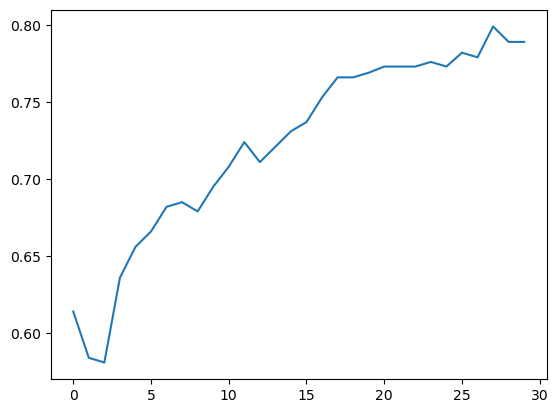

In [32]:
from matplotlib import pyplot as plt

plt.plot(results['accuracies'])

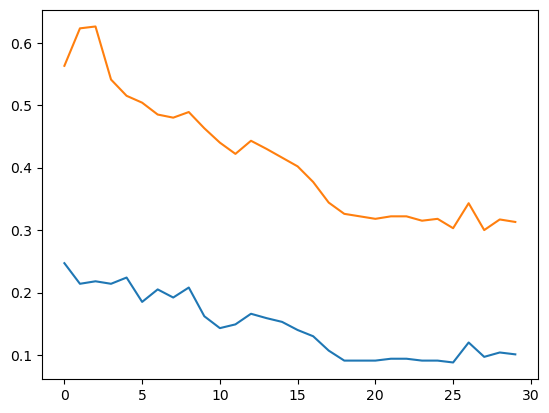

In [36]:
plt.plot(results['ece'])
plt.plot(results['mce'])

In [37]:
X_test.shape

(308, 8)

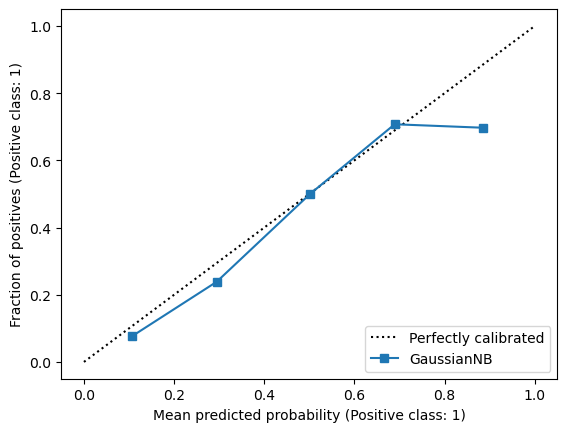

In [43]:
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression

from sklearn.calibration import CalibrationDisplay

disp = CalibrationDisplay.from_estimator(classifier, X_test, y_test)
plt.show()

In [44]:
get_calibration_errors(y_test, classifier.predict(X_test))

(array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.31313131]),
 array([ 0,  0,  0,  0,  0,  0,  0,  0,  0, 99]))

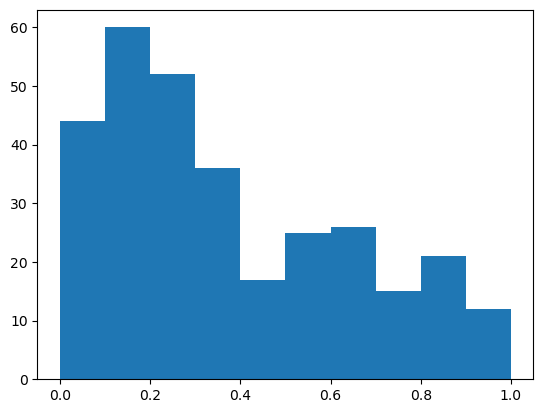

In [39]:
plt.hist(
	disp.y_prob,
	range=(0,1),
	bins=10,
	)
plt.show()